In [2]:
import os
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np

In [3]:
TRACKS_5 = ['CS13','CS14','CS15','CS17','CS20']
results_folder = '/home/chent9/projects/enformer-pytorch/results'
model_name = 'H3K27ac_batchsize_4_lr1e-5_clip0.5_noamp_chromsplit811_log1p_1'
data_with_preds = torch.load(os.path.join(results_folder, model_name, 'data_with_predictions.pt'), weights_only=False, map_location='cpu')

In [ ]:
# functinal gold standard variant 11119348 (index 214), 661849 (index 222)
# preds shape [896, 5] [num_bins, num_tracks], extract variant-centered predictions [448-48:448+48]

In [4]:
data_with_preds[222]

{'rs_id': 'rs661849',
 'chrom': 'chr1',
 'target_start': 209770543,
 'target_end': 209885231,
 'alt_pos': 209827887,
 'alt_info': 'C>T',
 'target': array([[3.55423314, 3.65830814, 4.03424051, 3.51541855, 4.27109508],
        [3.26774978, 3.38308945, 3.78187575, 3.2643175 , 3.90358753],
        [3.10949839, 3.20451891, 3.43906169, 3.09967553, 3.96366626],
        ...,
        [3.95928824, 4.40472947, 4.21253236, 3.968323  , 3.96556377],
        [3.77954249, 4.20129432, 3.88884899, 3.71362696, 3.73504715],
        [3.59172407, 3.93821742, 3.77724114, 3.48725272, 3.36072257]]),
 'seqs': {'chr1:209827887_C>T|ref': 'CACCAAGAAGGACAAAGGATTGGGAAGGAGAGACTGGCTTCTCCTTTTAAGGATGTGTCCCAACATTGAAACCAAAACTAAAGATACAACAAAAAAGAGAAAACCACAGGCCAATATCCCTGATGAACACAGATGCAAAAATCCTCAACAAAATACTAGCAAACAGAGCTCAACAACATTTTAAAGGATCATTCATTATGATCAAGTAGGATTCATCTTCAAGATGCAAGGATGGTTCAACATAAGCAAATCAATAAATGTGATACATCACATCAACAGAATCAAAGGCAAAAATATATAATCATTTCAGTAGATGATGAAAAAGCATTTGGTAAAATGCAATATCCCTTCATAATAAAAACCCTCAACAAATTGGGTATA

In [4]:
# get functional and nonfunctional variants predictions
functional_rsids = ['rs11119348', 'rs661849']
functional_preds = []
nonfunctional_preds = []
for i in range(len(data_with_preds)):
    rsid = data_with_preds[i]['rs_id']
    if rsid in functional_rsids:
        functional_preds.append(data_with_preds[i]['preds'])
    else:
        nonfunctional_preds.append(data_with_preds[i]['preds'])

In [ ]:
import numpy as np

def variant_effect_score(y_ref, y_alt, agg='sum', eps=1e-6):
    """
    Compute per-task and scalar effect score for one variant.

    Args:
        y_ref: array, shape (num_bins, num_tasks)
        y_alt: array, shape (num_bins, num_tasks)
        agg:   'sum' or 'mean' across bins
        eps:   small constant to avoid log(0)

    Returns:
        delta_tasks: (num_tasks,)      sum/mean of (alt - ref) over bins
        logfc_tasks: (num_tasks,)      mean log2FC over bins
        score:       scalar            overall effect magnitude for this variant
    """
    y_ref = np.asarray(y_ref)
    y_alt = np.asarray(y_alt)

    # bin-wise differences
    delta_bins = y_alt - y_ref                      # (B, T)
    logfc_bins = np.log2((y_alt + eps) / (y_ref + eps))

    # aggregate over bins → per-task
    if agg == 'sum':
        delta_tasks = delta_bins.sum(axis=0)        # (T,)
    elif agg == 'mean':
        delta_tasks = delta_bins.mean(axis=0)
    else:
        raise ValueError("agg must be 'sum' or 'mean'")

    logfc_tasks = logfc_bins.mean(axis=0)           # (T,)

    score = np.max(np.abs(logfc_tasks))

    return delta_tasks, logfc_tasks, score



In [7]:
scores_func = []
scores_nonfunc = []
logfc_tasks_list = []
agg = 'sum'
eps = 1e-6

for i in range(len(functional_preds)):
    preds = list(functional_preds[i].values())
    y_ref, y_alt = preds[0], preds[1]
    _, logfc_tasks, score = variant_effect_score(y_ref[448-48:448+48], y_alt[448-48:448+48], agg=agg, eps=eps)
    logfc_tasks_list.append(logfc_tasks)
    scores_func.append(score)
    
scores_func = np.array(scores_func)

for i in range(len(nonfunctional_preds)):
    preds = list(nonfunctional_preds[i].values())
    y_ref, y_alt = preds[0], preds[1]
    _, logfc_tasks, score = variant_effect_score(y_ref[448-48:448+48], y_alt[448-48:448+48], agg=agg, eps=eps)
    logfc_tasks_list.append(logfc_tasks)
    scores_nonfunc.append(score)

scores_nonfunc = np.array(scores_nonfunc)
logfc_tasks_all = np.stack(logfc_tasks_list, axis=0)  # (N, num_tasks)


In [ ]:
# Group comparison: stats + AUC
from scipy.stats import mannwhitneyu, ttest_ind

def cohens_d(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    nx, ny = len(x), len(y)
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    pooled = ((nx - 1) * vx + (ny - 1) * vy) / (nx + ny - 2)
    return (x.mean() - y.mean()) / np.sqrt(pooled + 1e-12)

from sklearn.metrics import roc_auc_score

def compare_groups(scores_func, scores_nonfunc):
    """
    Compute summary statistics & classification AUC.
    """
    scores_func = np.asarray(scores_func)
    scores_nonfunc = np.asarray(scores_nonfunc)

    # Descriptive stats
    stats = {
        "mean_func": float(scores_func.mean()),
        "mean_nonfunc": float(scores_nonfunc.mean()),
        "median_func": float(np.median(scores_func)),
        "median_nonfunc": float(np.median(scores_nonfunc)),
    }

    # Mann-Whitney U-test (non-parametric)
    u_stat, p_mw = mannwhitneyu(scores_func, scores_nonfunc, alternative='two-sided')
    stats["mannwhitney_U"] = float(u_stat)
    stats["mannwhitney_p"] = float(p_mw)

    # Welch t-test (parametric, unequal variances)
    t_stat, p_t = ttest_ind(scores_func, scores_nonfunc, equal_var=False)
    stats["ttest_t"] = float(t_stat)
    stats["ttest_p"] = float(p_t)

    # Effect size
    stats["cohens_d"] = float(cohens_d(scores_func, scores_nonfunc))

    # AUC: can scores distinguish functional vs non-functional?
    y_true = np.concatenate([
        np.ones_like(scores_func),
        np.zeros_like(scores_nonfunc)
    ])
    y_score = np.concatenate([scores_func, scores_nonfunc])
    stats["auc"] = float(roc_auc_score(y_true, y_score))

    return stats


In [12]:
stats = compare_groups(scores_func, scores_nonfunc)
for key, value in stats.items():
    print(f"{key}: {value}")

mean_func: 0.004429922439157963
mean_nonfunc: 0.0009583568316884339
median_func: 0.004429922439157963
median_nonfunc: 0.00047779930173419416
mannwhitney_U: 1183.0
mannwhitney_p: 0.0036704139947948806
ttest_t: 3.935200404279325
ttest_p: 0.15589819206877803
cohens_d: 1.973862886428833
auc: 0.971264367816092


In [23]:
# Per-task AUC (which tracks best separate func vs non-func?)
# Here we look at per-task log2FC (from logfc_tasks_all).

def per_task_auc(logfc_tasks_all, labels, use_abs=True):
    """
    Compute per-task AUC for separating functional vs non-functional
    using per-task log2 fold-change.

    Args:
        logfc_tasks_all: (N, num_tasks)
        labels:          (N,) 1=functional, 0=non-functional
        use_abs:         if True, use abs(log2FC); else use signed log2FC

    Returns:
        aucs: np.array, shape (num_tasks,)
    """
    logfc_tasks_all = np.asarray(logfc_tasks_all)
    labels = np.asarray(labels)
    N, T = logfc_tasks_all.shape

    aucs = np.zeros(T)
    for t in range(T):
        scores_t = np.abs(logfc_tasks_all[:, t]) if use_abs else logfc_tasks_all[:, t]
        try:
            aucs[t] = roc_auc_score(labels, scores_t)
        except ValueError:
            # if only one class present, AUC undefined → NaN
            aucs[t] = np.nan

    return aucs


In [33]:
labels = [1] * len(scores_func) + [0] * len(scores_nonfunc)
task_aucs = per_task_auc(logfc_tasks_all, labels)
task_aucs

array([0.97454844, 0.96223317, 0.96387521, 0.97454844, 0.95484401])

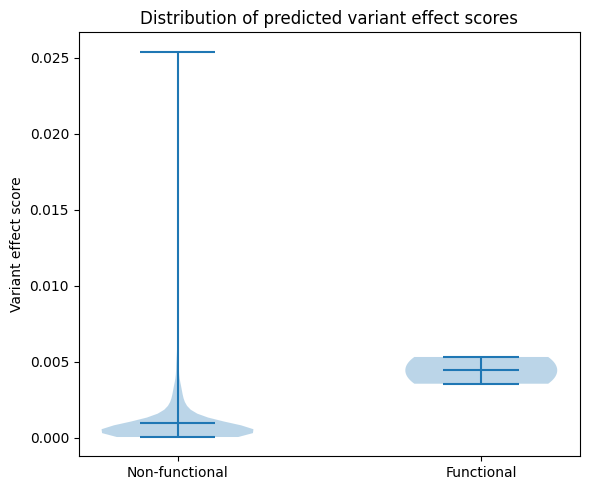

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# assume you already have:
# scores_func, scores_nonfunc

data = [scores_nonfunc, scores_func]
labels = ["Non-functional", "Functional"]

plt.figure(figsize=(6, 5))

# Violin plot
parts = plt.violinplot(
    data,
    positions=np.arange(1, len(data) + 1),
    showmeans=True,
    showmedians=False,
    showextrema=True
)

plt.xticks(np.arange(1, len(data) + 1), labels, rotation=0)
plt.ylabel("Variant effect score")
plt.title("Distribution of predicted variant effect scores")
# plt.yscale("log")
plt.tight_layout()
plt.show()


/tmp/ipykernel_2238779/1202144259.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


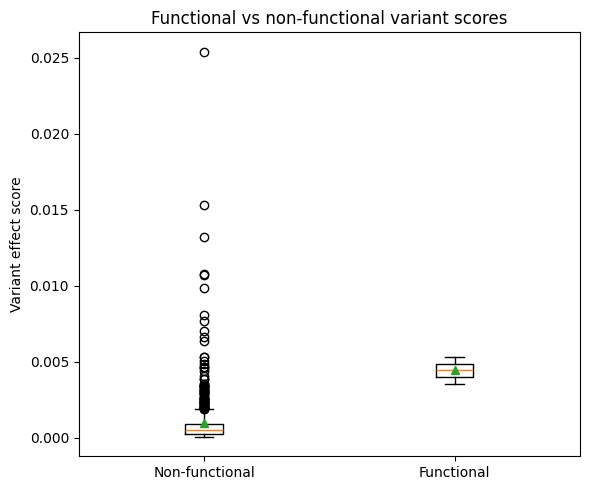

In [28]:
import matplotlib.pyplot as plt

data = [scores_nonfunc, scores_func]
labels = ["Non-functional", "Functional"]

plt.figure(figsize=(6, 5))

plt.boxplot(
    data,
    labels=labels,
    showmeans=True
)

plt.ylabel("Variant effect score")
plt.title("Functional vs non-functional variant scores")
# Optional:
# plt.yscale("log")

plt.tight_layout()
plt.show()


In [ ]:
# Compute mean / median per task (functional vs non-functional)
logfc_tasks_all = np.array(logfc_tasks_all)   # (N, 5)
labels = [1] * len(scores_func) + [0] * len(scores_nonfunc)
labels = np.array(labels)                    # (N,)

func = logfc_tasks_all[labels == 1]          # (N_func, 5)
nonfunc = logfc_tasks_all[labels == 0]       # (N_nonfunc, 5)

mean_func_per_task = func.mean(axis=0)
mean_nonfunc_per_task = nonfunc.mean(axis=0)

median_func_per_task = np.median(func, axis=0)
median_nonfunc_per_task = np.median(nonfunc, axis=0)

print(mean_func_per_task)
print(mean_nonfunc_per_task)


[-0.00434045 -0.00291362 -0.0029964  -0.00370986 -0.00325302]
[-8.3703540e-05 -6.7353976e-05 -6.8780239e-05 -7.7825287e-05
 -7.1713279e-05]


/tmp/ipykernel_2238779/663424523.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


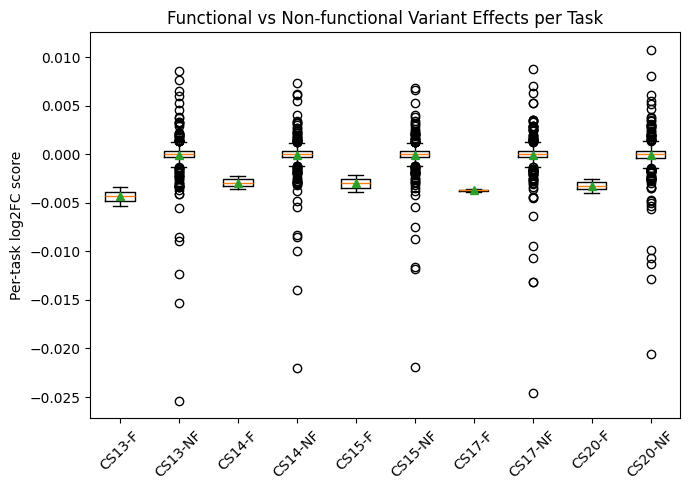

In [36]:
import matplotlib.pyplot as plt

task_names = ['CS13','CS14','CS15','CS17','CS20']

plt.figure(figsize=(7,5))

data = [
    func[:,0], nonfunc[:,0],   # CS13
    func[:,1], nonfunc[:,1],   # CS14
    func[:,2], nonfunc[:,2],   # CS15
    func[:,3], nonfunc[:,3],   # CS17
    func[:,4], nonfunc[:,4],   # CS20
]

labels = [
    "CS13-F", "CS13-NF",
    "CS14-F", "CS14-NF",
    "CS15-F", "CS15-NF",
    "CS17-F", "CS17-NF",
    "CS20-F", "CS20-NF",
]

plt.boxplot(data, labels=labels, showmeans=True)
plt.xticks(rotation=45)
plt.ylabel("Per-task log2FC score")
plt.title("Functional vs Non-functional Variant Effects per Task")

plt.tight_layout()
plt.show()


In [37]:
# Per-task significance test
from scipy.stats import mannwhitneyu

pvals = []
for t in range(func.shape[1]):
    stat, p = mannwhitneyu(func[:,t], nonfunc[:,t])
    pvals.append(p)

for name, p in zip(task_names, pvals):
    print(name, p)


CS13 0.0009658984196828633
CS14 0.002253762979260014
CS15 0.0018137425880711542
CS17 0.0011805425129457216
CS20 0.002919159668374876


In [38]:
# Per-task effect size (Cohen's d)
def cohens_d(a, b):
    return (np.mean(a) - np.mean(b)) / np.sqrt(((np.std(a)**2 + np.std(b)**2)/2))

ds = [cohens_d(func[:,t], nonfunc[:,t]) for t in range(5)]

for name, d in zip(task_names, ds):
    print(name, d)


CS13 -2.9654298
CS14 -2.3359523
CS15 -2.3254101
CS17 -2.893389
CS20 -2.3939123


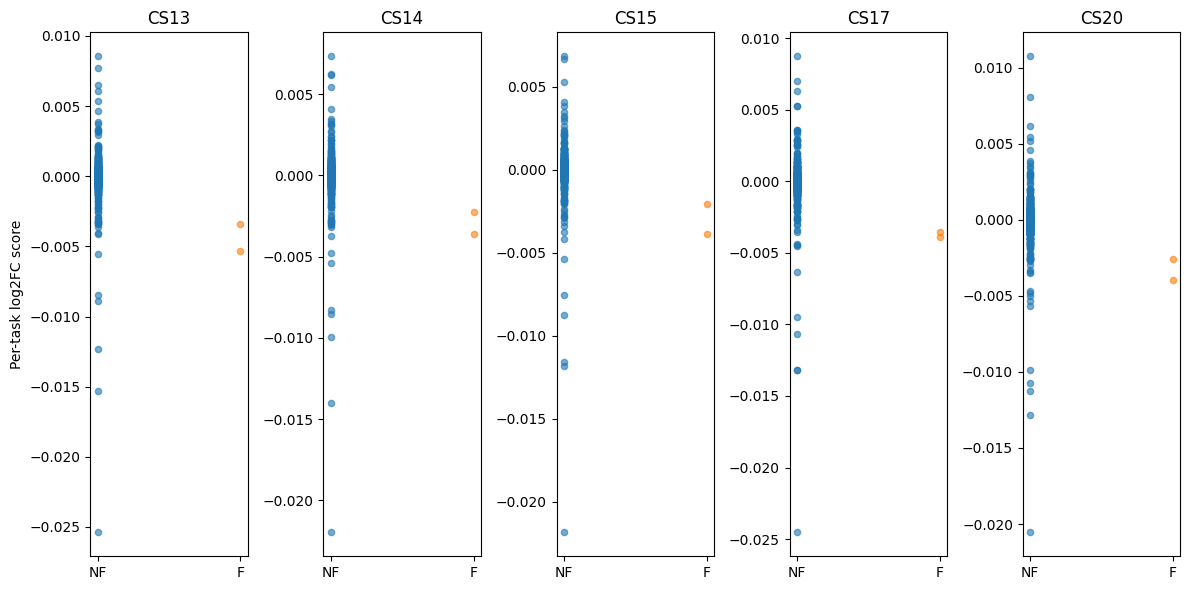

In [46]:
import numpy as np
import matplotlib.pyplot as plt
labels = [1] * len(scores_func) + [0] * len(scores_nonfunc)
labels = np.array(labels)                    # (N,)

func = logfc_tasks_all[labels == 1]      # (N_func, 5)
nonfunc = logfc_tasks_all[labels == 0]   # (N_nonfunc, 5)

task_names = ['CS13','CS14','CS15','CS17','CS20']

plt.figure(figsize=(12, 6))

for i, task in enumerate(task_names):
    plt.subplot(1, 5, i+1)
    
    # scatter points for this task
    plt.scatter(
        np.zeros(len(nonfunc)), nonfunc[:, i],
        alpha=0.6, label="Non-functional", s=20
    )
    plt.scatter(
        np.ones(len(func)), func[:, i],
        alpha=0.6, label="Functional", s=20
    )

    plt.xticks([0, 1], ["NF", "F"])
    plt.title(task)
    
    if i == 0:
        plt.ylabel("Per-task log2FC score")

plt.tight_layout()
plt.show()


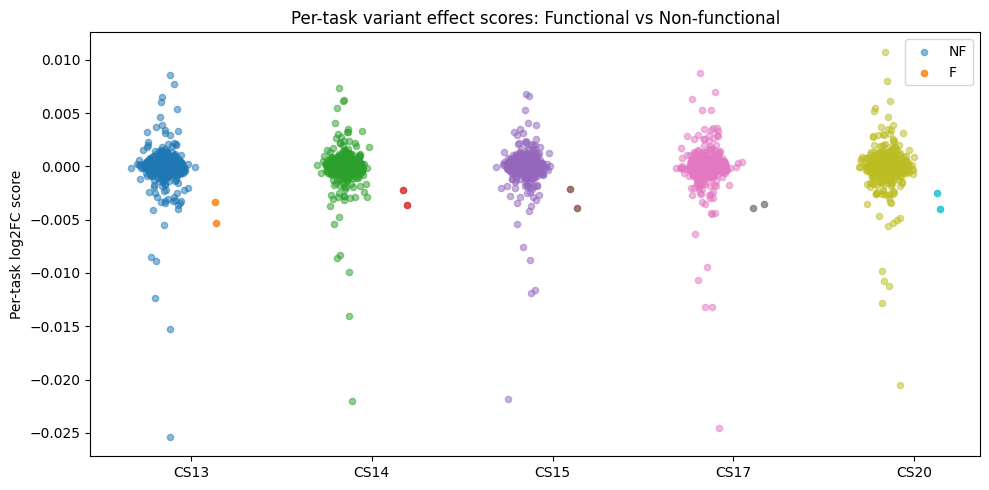

In [45]:
import numpy as np
import matplotlib.pyplot as plt

labels = [1] * len(scores_func) + [0] * len(scores_nonfunc)
labels = np.array(labels)                    # (N,)

task_names = ['CS13','CS14','CS15','CS17','CS20']
func = logfc_tasks_all[labels == 1]
nonfunc = logfc_tasks_all[labels == 0]

plt.figure(figsize=(10,5))

for i, task in enumerate(task_names):
    # jitter the x positions
    x_nf = i - 0.15 + 0.05 * np.random.randn(len(nonfunc))
    x_f  = i + 0.15 + 0.05 * np.random.randn(len(func))

    plt.scatter(x_nf, nonfunc[:, i], alpha=0.5, label="NF" if i==0 else "", s=20)
    plt.scatter(x_f, func[:, i], alpha=0.8, label="F" if i==0 else "", s=20)

plt.xticks(np.arange(len(task_names)), task_names)
plt.ylabel("Per-task log2FC score")
plt.title("Per-task variant effect scores: Functional vs Non-functional")
plt.legend()
plt.tight_layout()
plt.show()


